# Virtual Sensor Prototype
This notebook demonstrates a virtual sensor pipeline:
- generate synthetic dataset
- engineer features
- train simple ML models (Ridge, RandomForest)
- evaluate predictions and show plots

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

DATA = Path("../data/virtual_sensor_data.csv")
df = pd.read_csv(DATA)
df.head()

,time,hidden_load,accel,gyro,strain
0,0.000000,5.149014,2.438808,1.129988,3.674068
1,0.010001,4.958561,2.437030,1.083799,3.753098
2,0.020002,5.194387,2.515341,0.949616,4.058736
3,0.030003,5.457029,2.806848,1.231170,4.453005
4,0.040004,4.929914,2.779047,0.816888,4.249909


## Visualize raw signals and hidden load

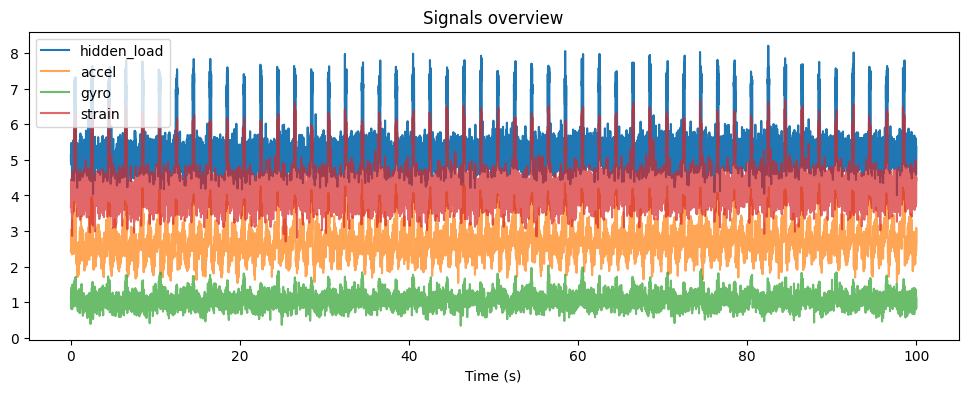

In [4]:
plt.figure(figsize=(12,4))
plt.plot(df["time"], df["hidden_load"], label="hidden_load")
plt.plot(df["time"], df["accel"], label="accel", alpha=0.7)
plt.plot(df["time"], df["gyro"], label="gyro", alpha=0.7)
plt.plot(df["time"], df["strain"], label="strain", alpha=0.7)
plt.legend()
plt.title("Signals overview")
plt.xlabel("Time (s)")
plt.show()

In [5]:
## Feature engineering (rolling means, lags)
def feature_engineer(df):
    df = df.copy()
    df["accel_roll5"] = df["accel"].rolling(5, min_periods=1).mean()
    df["gyro_roll5"] = df["gyro"].rolling(5, min_periods=1).mean()
    df["strain_roll5"] = df["strain"].rolling(5, min_periods=1).mean()
    df["accel_lag1"] = df["accel"].shift(1).fillna(method="bfill")
    df["gyro_lag1"] = df["gyro"].shift(1).fillna(method="bfill")
    df["strain_lag1"] = df["strain"].shift(1).fillna(method="bfill")
    df["accel_strain_ratio"] = (df["accel"] / (df["strain"] + 1e-6)).replace([np.inf, -np.inf], 0)
    return df

df_feat = feature_engineer(df)
df_feat[['hidden_load','accel','accel_roll5','accel_lag1']].head()

/var/folders/1t/l4lsv7cx6cdfdd7rbml1j2dh0000gn/T/ipykernel_92161/2713900684.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["accel_lag1"] = df["accel"].shift(1).fillna(method="bfill")
/var/folders/1t/l4lsv7cx6cdfdd7rbml1j2dh0000gn/T/ipykernel_92161/2713900684.py:8: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["gyro_lag1"] = df["gyro"].shift(1).fillna(method="bfill")
/var/folders/1t/l4lsv7cx6cdfdd7rbml1j2dh0000gn/T/ipykernel_92161/2713900684.py:9: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["strain_lag1"] = df["strain"].shift(1).fillna(method="bfill")


,hidden_load,accel,accel_roll5,accel_lag1
0,5.149014,2.438808,2.438808,2.438808
1,4.958561,2.437030,2.437919,2.438808
2,5.194387,2.515341,2.463726,2.437030
3,5.457029,2.806848,2.549507,2.515341
4,4.929914,2.779047,2.595415,2.806848


In [6]:
## Train-Test split and simple Ridge model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

X = df_feat[["accel", "gyro", "strain", "accel_roll5", "gyro_roll5", "strain_roll5",
             "accel_lag1", "gyro_lag1", "strain_lag1", "accel_strain_ratio"]].values
y = df_feat["hidden_load"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge(alpha=1.0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 :", r2_score(y_test, y_pred))

MSE: 0.04932423689686109
R2 : 0.8885824467527269


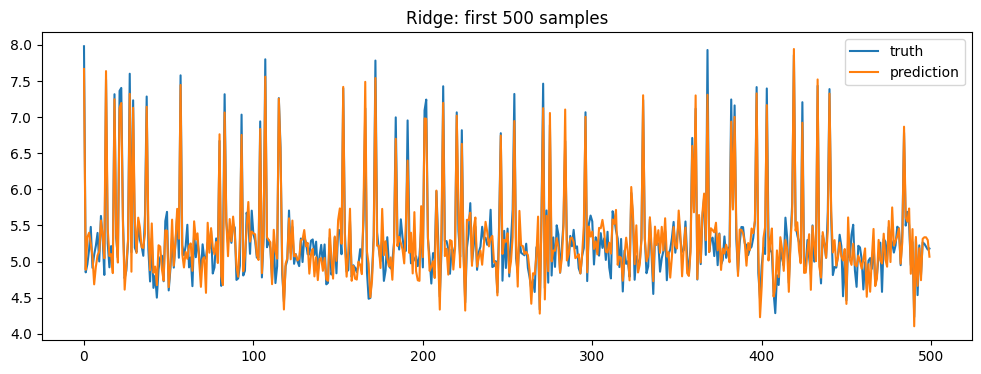

In [7]:
## Plot predictions vs truth
plt.figure(figsize=(12,4))
plt.plot(y_test[:500], label="truth")
plt.plot(y_pred[:500], label="prediction")
plt.legend()
plt.title("Ridge: first 500 samples")
plt.show()

In [8]:
## Quick RandomForest baseline
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RF MSE:", mean_squared_error(y_test, y_pred_rf), "R2:", r2_score(y_test, y_pred_rf))

RF MSE: 0.04084798837252282 R2: 0.9077292786291604


In [9]:
## Save the Ridge model as an example
import joblib
joblib.dump(model, "../models/virtual_sensor_ridge.joblib")
print("Model saved to models/")

Model saved to models/
